# A Study on Gradient Boosting Algorithms and Hyperparameter Optimization using Optuna

Undergraduate Thesis submitted to the Undergraduate Course in Mechatronics Engineering from São Carlos School of Engineering, University of São Paulo – EESC- USP, in partial fulfillment of the requirements for the bachelor degree in Mechatronics Engineer .

In [6]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sys
import timeit
import gc
import sklearn
import seaborn
from sklearn import metrics
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import optuna
from sklearn.model_selection import GridSearchCV
import matplotlib.pylab as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
import shap
import validation_train
from validation_train import auc_logloss_ks
from validation_train import objective
from validation_train import tuning
from validation_train import train
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

# 3.0 - Kdney Stone Dataset
[Kidney Stone](https://www.kaggle.com/datasets/vuppalaadithyasairam/kidney-stone-prediction-based-on-urine-analysis)

In [2]:
df_kindey = pd.read_csv('03_kindey_stone_dataset.csv')
df_kindey

,gravity,ph,osmo,cond,urea,calc,target
0,1.021,4.910,725,14.000,443,2.450,0
1,1.017,5.740,577,20.000,296,4.490,0
2,1.008,7.200,321,14.900,101,2.360,0
3,1.011,5.510,408,12.600,224,2.150,0
4,1.005,6.520,187,7.500,91,1.160,0
...,...,...,...,...,...,...,...
74,1.025,7.900,721,23.600,301,9.040,1
75,1.017,4.810,410,13.300,195,0.580,1
76,1.024,5.400,803,21.800,394,7.820,1
77,1.016,6.810,594,21.400,255,12.200,1


In [4]:
# columns name
df_kindey.columns

Index(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target'], dtype='object')

In [5]:
# columns type
df_kindey.dtypes

gravity    float64
ph         float64
osmo         int64
cond       float64
urea         int64
calc       float64
target       int64
dtype: object

In [6]:
# check for null
df_kindey.isnull().sum()

gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
target     0
dtype: int64

In [7]:
df_kindey.describe()

,gravity,ph,osmo,cond,urea,calc,target
count,79.000,79.000,79.000,79.000,79.000,79.000,79.000
mean,1.018,6.028,612.848,20.814,266.405,4.139,0.430
std,0.007,0.724,237.515,7.939,131.255,3.260,0.498
min,1.005,4.760,187.000,5.100,10.000,0.170,0.000
25%,1.012,5.530,413.000,14.150,160.000,1.460,0.000
50%,1.018,5.940,594.000,21.400,260.000,3.160,0.000
75%,1.023,6.385,792.000,26.550,372.000,5.930,1.000
max,1.040,7.940,1236.000,38.000,620.000,14.340,1.000


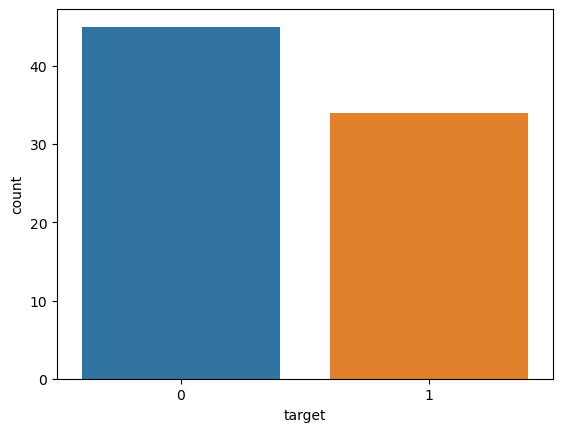

In [8]:
seaborn.countplot(x = 'target',data = df_kindey)
plt.savefig('kindey_tot.png')

<Figure size 2500x2500 with 0 Axes>

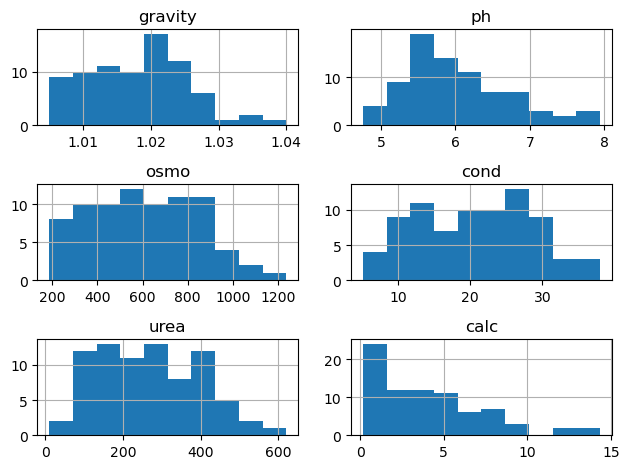

In [9]:
plt.figure(figsize = (25,25))
df_kindey[['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']].hist()
plt.tight_layout()
plt.savefig('hist_kindey_t.png')

<Figure size 2500x2500 with 0 Axes>

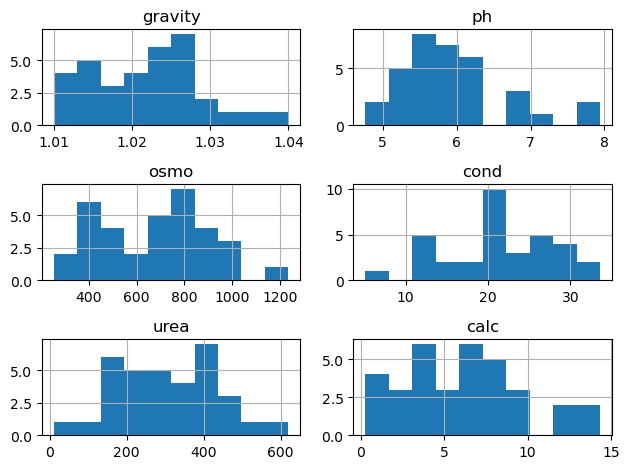

In [10]:
plt.figure(figsize = (25,25))
df_kindey[['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']].loc[df_kindey['target']==1].hist()
plt.tight_layout()
plt.savefig('hist_kindey_yes.png')

<Figure size 2500x2500 with 0 Axes>

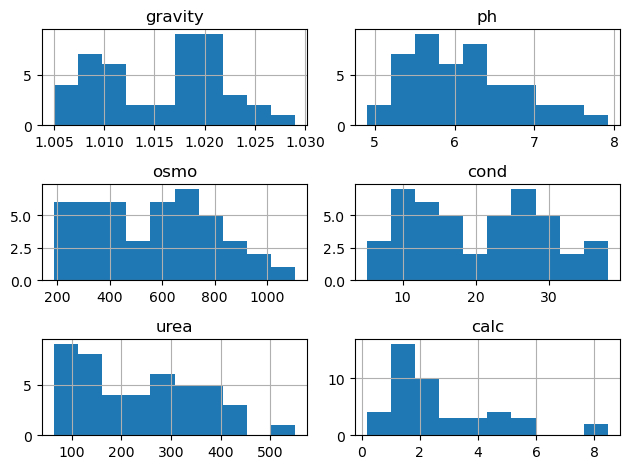

In [11]:
plt.figure(figsize = (25,25))
df_kindey[['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']].loc[df_kindey['target']==0].hist()
plt.tight_layout()
plt.savefig('hist_kindey_no.png')

## XGBoost

In [3]:
var_cols = df_kindey.drop(columns='target').columns
var_cols

Index(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc'], dtype='object')

In [4]:
X = df_kindey.loc[:,var_cols]
y = df_kindey.loc[:,'target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((55, 6), (24, 6), (55,), (24,))

In [100]:
parameters = {
        'learning_rate': 0.3,
        'max_depth': 3,
        'lambda': 0.05
}

In [101]:
XGBoost_class = XGBClassifier(**parameters)

In [102]:
start = timeit.default_timer()
XGBoost_model = XGBoost_class.fit(X_train, y_train)
stop = timeit.default_timer()
stop - start

0.0994029080029577

In [103]:
y_prob = XGBoost_model.predict(X_test)
auc_logloss_ks(y_test, y_prob)

(0.6428571428571429, 11.513025414649002, 0.2857142857142857)

### XGBoost using optuna

In [44]:
XGBoost_model, study_xgb = train(X_train, y_train, X_test, y_test, balanced='balanced', method='XGBoost')

In [43]:
# optuna.visualization.plot_optimization_history(study_xgb)

In [42]:
# optuna.visualization.plot_param_importances(study_xgb)

In [45]:
# optuna.visualization.plot_slice(study_xgb, ['min_child_weight'])

In [46]:
# optuna.visualization.plot_slice(study_xgb, ['learning_rate'])

In [47]:
# optuna.visualization.plot_slice(study_xgb, ['max_depth'])

In [48]:
# optuna.visualization.plot_slice(study_xgb, ['lambda'])

## CatBoost

In [92]:
parameters = {
        'learning_rate': 0.3,
        'depth': 3,
        'l2_leaf_reg': 0.05
}

In [93]:
CatBoost_Classifier = CatBoostClassifier(**parameters)

In [94]:
# Fit model
start = timeit.default_timer()
CatBoost_model = CatBoost_Classifier.fit(X_train, y_train,verbose=False)
stop = timeit.default_timer()
stop - start

0.27348275200347416

In [95]:
y_prob = CatBoost_model.predict(X_test)
auc_logloss_ks(y_test, y_prob)

(0.7428571428571428, 8.634794048406446, 0.48571428571428565)

## CatBoost using Optuna

In [16]:
CatBoost_model, study_cat = train(X_train, y_train, X_test, y_test, balanced='balanced', method='CATBoost')

In [37]:
# optuna.visualization.plot_optimization_history(study_cat)

In [32]:
# optuna.visualization.plot_param_importances(study_cat)

In [33]:
# optuna.visualization.plot_slice(study_cat, ['depth'])

In [34]:
# optuna.visualization.plot_slice(study_cat, ['learning_rate'])

In [35]:
# optuna.visualization.plot_slice(study_cat, ['min_data_in_leaf'])

In [36]:
# optuna.visualization.plot_slice(study_cat, ['l2_leaf_reg'])

## LightGBM

In [84]:
parameters = {
        'learning_rate': 0.3,
        'max_depth': 3,
        'lambda_l2': 0.05
}

In [85]:
LGBM_Classifier = LGBMClassifier(**parameters)

In [86]:
start = timeit.default_timer()
LGBM_model = LGBM_Classifier.fit(X_train, y_train)
stop = timeit.default_timer()
stop - start

[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05


0.06458719800139079

In [87]:
y_prob = LGBM_model.predict(X_test)
auc_logloss_ks(y_test,y_prob)

(0.7285714285714286, 8.634760731846853, 0.45714285714285713)

## LGBM using Optuna

In [17]:
LGBM_model, study_lgbm = train(X_train, y_train, X_test, y_test, balanced='balanced', method='LGBM')

In [27]:
# optuna.visualization.plot_optimization_history(study_lgbm)

In [26]:
# optuna.visualization.plot_param_importances(study_lgbm)

In [51]:
# optuna.visualization.plot_slice(study_lgbm, ['bagging_fraction'])

In [22]:
# optuna.visualization.plot_slice(study_lgbm, ['lambda_l1'])

In [23]:
# optuna.visualization.plot_slice(study_lgbm, ['learning_rate'])

In [24]:
# optuna.visualization.plot_slice(study_lgbm, ['min_data_in_leaf'])

In [25]:
# optuna.visualization.plot_slice(study_lgbm, ['max_depth'])

# SHAP for model with best perfom

In [113]:
explainer = shap.TreeExplainer(XGBoost_model)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


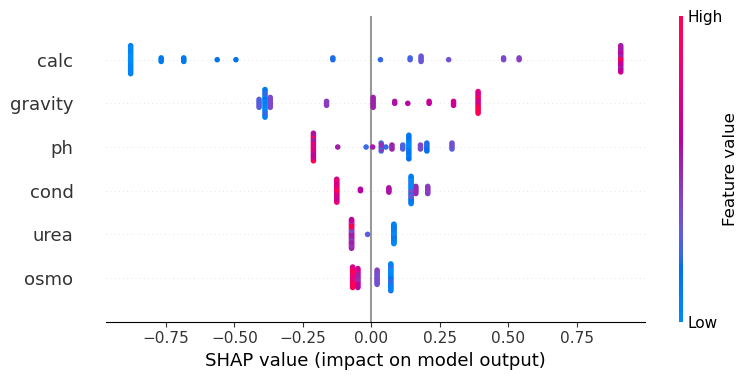

In [115]:
shap.summary_plot(shap_values, X_train,show=False)
plt.savefig('shap_kidney.png')

## Default Results

||	XGBoost|CatBoost|	LightGBM|
|---|---|---|---|
AUC|	0.60714|	0.72857	|0.72857|
logloss	|12.95217	|8.63476	|8.63476
KS	|0.21429	|0.45714	|0.45714
time (s)	|0.08901	|0.47443|	0.05795|

## Optuna results (1h tuning for each model)

			
||	XGBoost|CatBoost|	LightGBM|
|---|---|---|---|
AUC|	0.87857	|0.84286	|0.86786|
logloss	|0.51145	|0.64940	|0.46334|
KS	|0.72857	|0.67143	|0.61429|